# Lesson 2 - Image Classification & EDA

**미션 개요**
- Computer Vision EDA 배우기

**미션의 목적 및 배경**
- 2강에서는 데이터를 분석하는 과정인 EDA(Exploratory Data Analysis)에 대해 진행되었습니다. 모델을 설계하는데 있어 데이터를 분석하는 작업은 중요합니다. 이 실습 자료에서는 마스크 데이터셋을 이용하여 간단한 분석 및 시각화를 해봅니다.

**미션 수행으로 얻어갈 수 있는 역량**
- 데이터셋을 처음 접했을 때, 데이터의 전체 분포와 특징을 파악하기 위한 탐험적인 분석 방법을 익힐 수 있습니다.
- 마스크 데이터셋에는 다양한 정보가 존재합니다. 넓은 시야에서 모든 사람의 정보를 수집하여 성별과 연령에 대한 분포를 분석할 수도 있고 이미지 값의 분포를 파악할 수 있습니다. 혹은 개별 이미지를 시각화하여 어떠한 데이터가 있는지 탐색할 수도 있고 마스크의 유무에 따라 이미지가 어떻게 다른지 비교해볼 수도 있겠죠. 이 코드는 단순한 예시이며 이 보다 더 많은 분석을 자유롭게 할 수 있습니다!

**데이터셋 개요 및 저작권 정보**
- Face with Masks
- 캠프 교육용 라이선스 : 교육 내에서만 활용해 주시고, 일부 이미지라도 외부에 노출되는 일은 없도록 부탁드립니다. (데이터셋에 대한 설명글이나, 데이터셋을 활용하여 학습한 weight 정도가 공개 가능합니다)


**레퍼런스**
- [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
- [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)
- [Seaborn docs](https://seaborn.pydata.org/index.html)
- [Face Detection in 2 Minutes using OpenCV & Python](https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81)

## 0. Libraries & Configurations

In [1]:
# !pip install tqdm
# !pip install seaborn

In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

from base import DATA_DIR

['train.csv', 'images']


In [45]:
class cfg:
    data_dir = TRAIN_DATA_DIR
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [46]:
TRAIN_DATA_DIR = DATA_DIR + "/train"
EVAL_DATA_DIR = DATA_DIR + "/eval"

In [47]:
TRAIN_DATA_DIR

'../input/data/train'

# Label 계산 공식

Wear / Incorrect / Not wear : 0,1,2로 해서 5를 곱한다음에
male /female : 0,1로 해서 3을 곱한다음에 더함
<30, 30~60, >60 : 0,1,2로 구분하면 충분함

즉  6 xmask여부   + 3x gender   + age로 전체 label을 예측할 수 있음
(mask 착용여부당 발생 경우의 수가 6가지, gender 여부당 age 경우가 3가지이므로)

In [149]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()
INITIAL_SHAPE = df.shape[0]

def make_full_metadata(df, istrain = True, initial_shape = INITIAL_SHAPE):
    """
    확장자 문제 : jpg, jpeg, png를 해결해야 함 => glob pattern을 이용하던가 하자
    
    TRAIN_DATA_DIR : 학습 데이터가 있는 곳!
    """
    df["tmp"] = TRAIN_DATA_DIR + "/images/" +  df["path"]
    df["fullpath"] = df["tmp"].apply(lambda x: [x+"/"+label for label in num2class])
    
    if df.shape[0]< INITIAL_SHAPE * 7:
        df = df.explode("fullpath")
        
    def mask_split(x):
        ext = x.split("/")[-1]
        if ext.startswith("mask") : return 0
        elif ext.startswith("incorrect") : return 1
        else: return 2
        
    if istrain:
        df["new_gender"] = df["gender"].map({"female": 0, "male":1})
        df["new_age"] = df["age"].apply(lambda x: int(x>=60) + int(x>=30))  # 60살 이상이면 2, 30~60이면 1, 그 외엔 0
        df["new_mask"] = df["fullpath"].apply(mask_split)
        df["final_label"] = 6 * df["new_mask"] + 3 * df["new_gender"] + df["new_age"]
    df.reset_index(inplace = True, drop = True)
    return df

In [152]:
df = make_full_metadata(df)

AttributeError: 'list' object has no attribute 'split'

In [153]:
df

,id,gender,race,age,path,tmp,fullpath,new_gender,new_age,new_mask,final_label
0,000001,female,Asian,45,000001_female_Asian_45,../input/data/train/images/000001_female_Asian_45,[../input/data/train/images/000001_female_Asia...,0,1,1,7
1,000001,female,Asian,45,000001_female_Asian_45,../input/data/train/images/000001_female_Asian_45,[../input/data/train/images/000001_female_Asia...,0,1,0,1
2,000001,female,Asian,45,000001_female_Asian_45,../input/data/train/images/000001_female_Asian_45,[../input/data/train/images/000001_female_Asia...,0,1,0,1
3,000001,female,Asian,45,000001_female_Asian_45,../input/data/train/images/000001_female_Asian_45,[../input/data/train/images/000001_female_Asia...,0,1,0,1
4,000001,female,Asian,45,000001_female_Asian_45,../input/data/train/images/000001_female_Asian_45,[../input/data/train/images/000001_female_Asia...,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_19,[../input/data/train/images/006959_male_Asian_...,1,0,0,3
18896,006959,male,Asian,19,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_19,[../input/data/train/images/006959_male_Asian_...,1,0,0,3
18897,006959,male,Asian,19,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_19,[../input/data/train/images/006959_male_Asian_...,1,0,0,3
18898,006959,male,Asian,19,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_19,[../input/data/train/images/006959_male_Asian_...,1,0,0,3


In [148]:
def make_new_column(df):
    df["fullpath"] = TRAIN_DATA_DIR + "/images/" +  df["path"]
    
    df[""]
    

## 1. 이미지 RGB정보, 사이즈
input이 될 이미지에 대한 분석으로 이미지의 각 채널별 정보, 사이즈, 객체 위치등을 이용하여 이미지의 특성들을 알아봅시다.

### 1.1 Dataset Statistics
- 여기에선 전체 이미지에 대해서 이미지의 개수와 크기, R, G, B 값의 평균과 표준편차를 계산합니다.

In [7]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [8]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [9]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800662 0.51224152 0.47766819]
RGB Standard Deviation: [0.21789488 0.23798859 0.25171667]


## 1.2 객체의 위치들 확인해보기 
- 조금 특수한 분석을 해봅시다. 이 부분은 강의 내용을 벗어나는 코드가 포함되어 있으므로 생략하셔도 괜찮습니다.
- 사람 얼굴을 찾는데 딥러닝이 사용되기 이전에, Haar Cascade라는 방법이 많이 사용되었습니다. 이 방법을 이용하여 간단하게 결과를 시각화 해봅시다.
- 코드가 제대로 실행이 되지않는다면, opencv에서 제공하는 [haarcascade_frontalface_default.xml](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml)파일을 현재 경로에 받아야합니다.

In [10]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [11]:
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)
for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    imgs.append(img)
imgs = np.array(imgs)

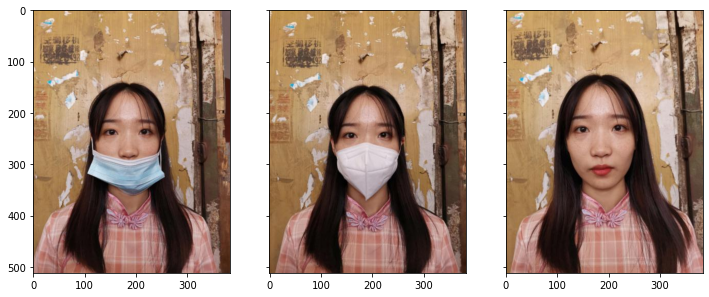

In [12]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

### 2. target값 y에 대한 분석
저희가 맞춰야하는 정보들이 어떤 것인지 확인해보고 어떤 분포를 갖고 있는지 확인해봅시다.

- 여기에선 train.csv에 저장되어있는 메타 데이터를 분석합니다. seaborn 시각화 라이브러리를 통해 성별의 분포와 연령 분포를 확인해봅시다.

### 2.1 y값 독립적 분포 확인

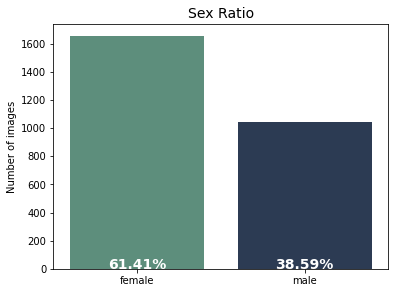

In [13]:
plt.figure(figsize=(6, 4.5)) 
ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Sex Ratio',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

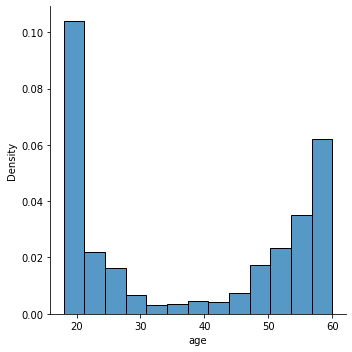

In [14]:
sns.displot(df, x="age", stat="density")
plt.show()

### 2.2 y값들 간의 관계 분포
- 나이와 성별에 따른 분포는 어떻게 구성되었는지 알아봅시다.

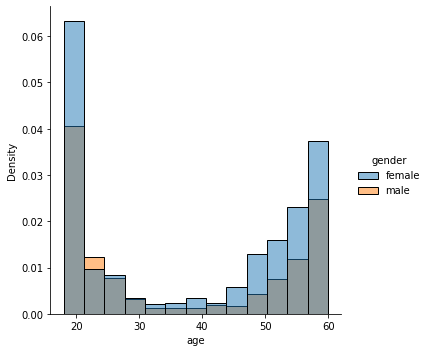

In [15]:
sns.displot(df, x="age", hue="gender", stat="density")
plt.show()

In [16]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

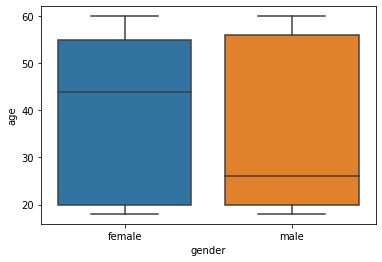

In [21]:
sns.boxplot(x='gender', y='age', data=df)
plt.show()

- 남성과 여성의 나이의 범위는 같지만 경향성은 다른 것을 확인할 수 있습니다.

- 데이터들의 불균형(data imbalance)가 심해보이네요 이를 위해서는 어떤 분석방법을 사용해야할까요??

### 3. X, y 관계확인
X인 이미지와 y의 관계는 어떤 것이 있을까요??
- 분석하고자 하는 이미지와 y의 관계를 알게된다면 전처리, data augmentation 혹은 CNN의 구조를 풀고자하는 문제에 적합하게 적용해볼 수 있습니다.

### 3.1 이미지 사이즈와 y값의 관계
- image size는 모두 같은 사이즈라 y값과 관계가 없습니다.

### 3.2 이미지 RGB 통계값과 y 특성의 관계

In [22]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

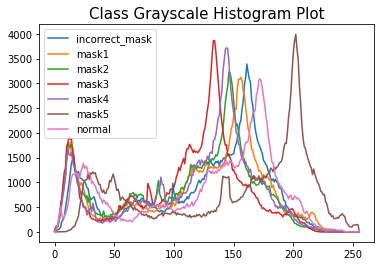

In [23]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

- 마스크의 종류가 5개라 plot이 산만한 것같으니 마스크는 평균을 취해서 확인해봅시다.

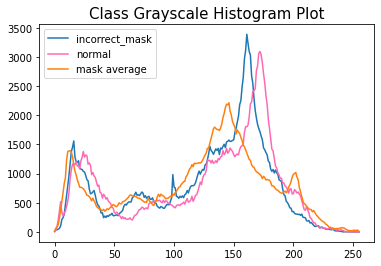

In [24]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

- 마스크를 쓰지않은 사진의 RGB 분포도 살펴볼까요?

No handles with labels found to put in legend.


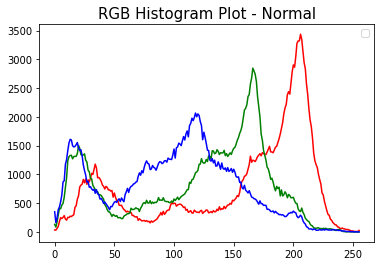

In [25]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()

### 3.3 객체의 위치와 y의 관계
객체의 위치와 y의 관계를 찾는 방법은 직접 다 확인하는 방법이 있을 수도 있지만 위에서 사용한 face detection을 이용하여 box의 위치들의 통계값들을 이용하여 찾을 수 있을 것 같습니다.

- 이미지 별로 통계값을 뽑아내는 것은 캠퍼님들이 직접 해보시면 좋을 것 같습니다.


- 아래 코드는 어떤 label이 얼굴을 잘찾지 못하는지 확인해봅시다.

In [26]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [27]:
imgs = []
bboxes = []
not_found_idx = []
img_id = df.iloc[504].path
ext = get_ext(cfg.img_dir, img_id)
for i, class_id in enumerate(num2class):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    bbox = face_cascade.detectMultiScale(img)
    imgs.append(img)
    if len(bbox) != 0:
        bboxes.append(bbox.max(axis=0))
    else:
        not_found_idx.append(i)
        print(f'{class_id} not found face')
imgs = np.array(imgs)
bboxes = np.array(bboxes)

incorrect_mask not found face
mask1 not found face
mask5 not found face


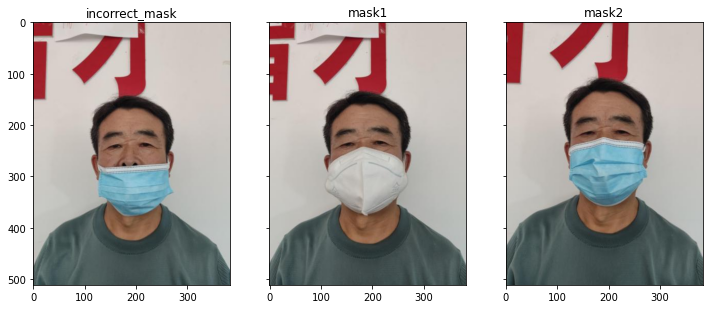

In [28]:
fig, axes = plt.subplots(1, len(not_found_idx), sharex=True, sharey=True, figsize=(12, 6))
for i, j in enumerate(range(len(not_found_idx))):
    axes[i].imshow(imgs[j])
    axes[i].set_title(f'{num2class[j]}')
plt.show()

- 대부분의 이미지들은 인물들이 정중앙에 있는 것으로 확인
- mask5는 대부분 bbox를 찾지 못함
- 가끔 mask1도 찾지 못함

### 3.4 데이터 노이즈 확인
- 사람마다 총 7장의 사진이 존재합니다. (마스크 정상 착용 5장, 미착용 1장, 이상하게 착용 1장).
- 이 파트에서는 이미지를 직접 시각화하여 눈으로 관찰하여 label에 문제가 없는지 확인해봅시다. 


한 사람의 데이터를 시각화해봅시다.

In [29]:
def plot_raw_images(img_dir, img_id):
    """
    마스크 미착용 이미지를 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)


In [30]:
def show_from_id(idx):
    img_id = df.iloc[idx].path
    gen = df.iloc[idx].gender
    age = df.iloc[idx].age
    plot_raw_images(cfg.img_dir, img_id)
    plt.title(f'{gen} {age}')
    plt.show()


- 남성으로 보이지만 여성으로 표시되어 있는경우

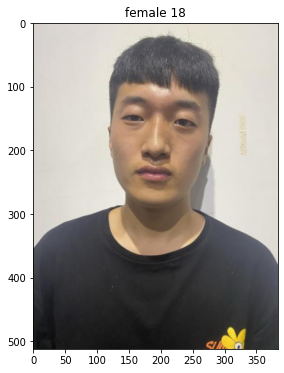

In [31]:
show_from_id(2399)

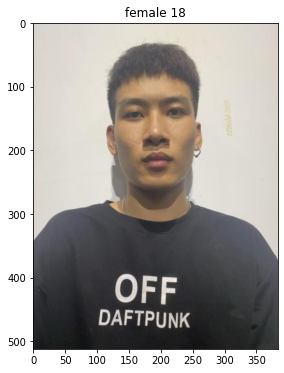

In [32]:
show_from_id(2400)

- 여성으로 보이지만 남성으로 표시되어 있는 경우

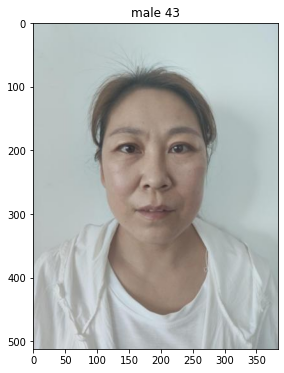

In [33]:
show_from_id(1912)

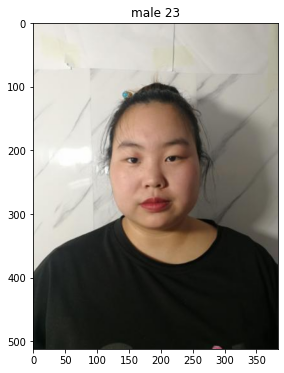

In [34]:
show_from_id(764)

꾀 많은 경우로 데이터의 경향성을 방해하는 데이터가 있는 것으로 확인됩니다. 

이를 위해서는 어떤 방법을 이용하는 것이 좋을까요???

- id 별로 마스크 착용 상태를 확인해봅시다.

In [35]:
def plot_mask_images(img_dir, img_id):
    """
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()
    plt.show()

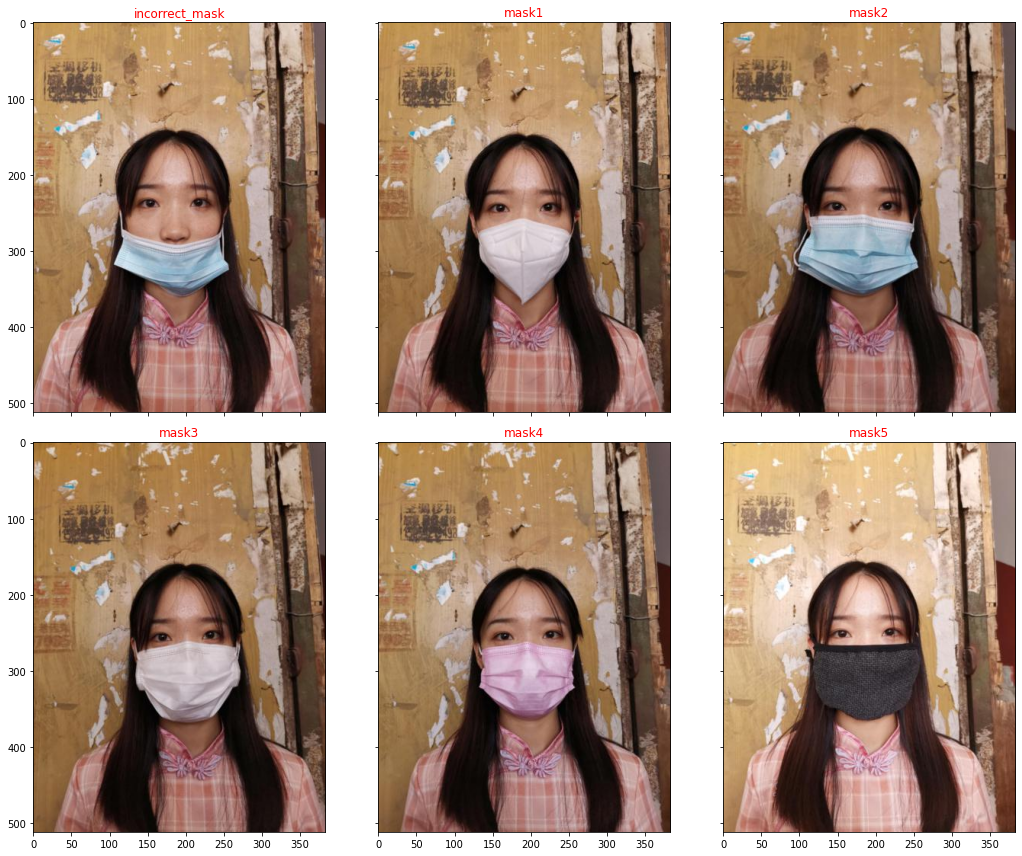

In [36]:
idx = 500
img_id = df.iloc[idx].path
plot_mask_images(cfg.img_dir, img_id)

### (Optional) PCA
- 주성분 분석은 이미지 데이터 분포의 주성분을 구하는 방법입니다.
- 300 장의 얼굴 이미지에 대한 주성분 벡터(eigenface)를 구하고 T-SNE를 통해 차원축소를 하여 각 클래스마다의 분포차이를 시각화해봅시다.

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [38]:
n_imgs = 100

imgs = []
for img_id in df.path.values[:n_imgs]:
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

In [39]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 6s
Explained variation per principal component: 
[0.16400328 0.10583061 0.07423401 0.05696065 0.03344143 0.02725811
 0.02416491 0.02329299 0.02024698 0.01692823 0.01573051 0.0135788
 0.01292895 0.0118508  0.01141356 0.00954073 0.0082221  0.00784373
 0.00709925 0.00670261 0.00646111 0.00626614 0.00592066 0.00564945
 0.00546344 0.00517093 0.00475178 0.00465655 0.00437079 0.00422397]


In [40]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [41]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,class_id
0,-0.780928,-0.301785,0.909879,0.561677,0.377160,0.319318,0.490583,-0.157288,0.226583,-0.055650,...,1.405176,0.693616,1.013604,1.019859,0.220020,-0.547624,0.035883,1.136905,-1.286375,incorrect_mask
1,-1.530998,0.054308,1.062859,0.448517,0.221639,0.127035,-0.152808,2.102633,2.525300,0.800276,...,-0.563898,-0.488880,-0.537816,-0.569975,1.157307,-0.681716,0.079725,0.416784,-0.523059,mask
2,-0.878974,-0.366530,0.961204,0.348114,0.147959,-0.001420,0.647866,-0.286866,0.415879,0.085198,...,0.994605,0.471021,0.436123,1.315718,-0.056314,-0.415704,0.032462,0.961481,-0.604543,mask
3,-0.354728,-0.443177,1.248912,0.965023,0.401113,0.732332,0.595702,-0.243740,0.063749,0.278055,...,1.054546,-0.560270,0.295105,0.385327,-0.822156,-0.641599,-0.853740,0.780486,-0.164744,mask
4,-0.526049,-0.342641,1.048807,0.778380,0.344757,0.535216,0.592012,-0.187867,0.033170,0.083710,...,1.542814,0.070895,1.002552,0.751363,-0.328542,-0.963397,-0.570438,1.312958,-1.431681,mask


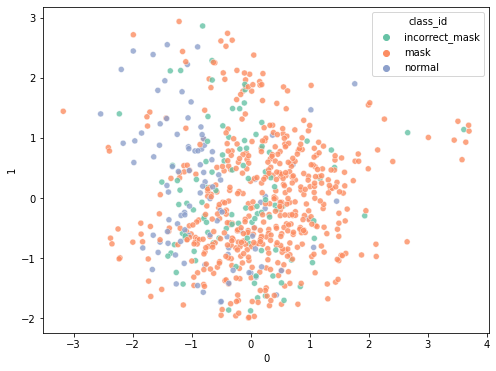

In [42]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)
plt.show()

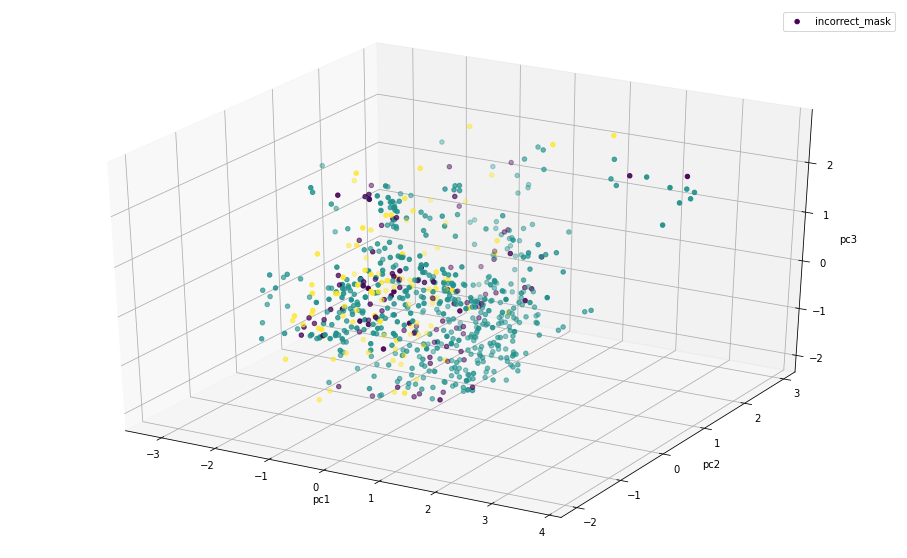

In [43]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"], 
    ys=pca_df["1"], 
    zs=pca_df["2"], 
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]), 
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [44]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.001s...
[t-SNE] Computed neighbors for 700 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 2.322687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.129196
[t-SNE] KL divergence after 300 iterations: 1.351316
t-SNE done! Time elapsed: 0.6972315311431885 seconds


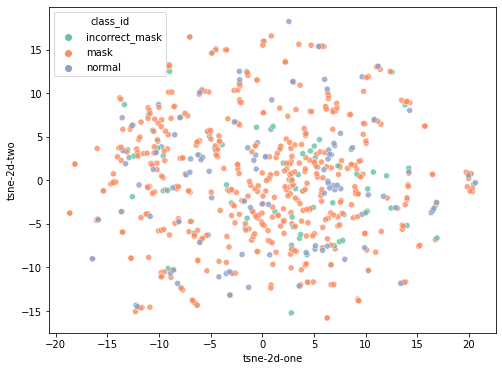

In [45]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()

**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.